# Imports

In [19]:
!pip install pandas==1.4.2
!pip install matplotlib==3.5.2
!pip install seaborn==0.11.2
!pip install nltk==3.7
!pip install scikit-learn==1.1.1

In [20]:
import pandas as pd

In [21]:
# Change the file directories to yours, the files are in a public folder in google drive:
# https://drive.google.com/drive/folders/1CsvJs0xZ9SCLtG4ci2dNGCkhqnI-1DLS?usp=drive_link
df_train_valid = pd.read_parquet('/content/drive/MyDrive/2022/Orga_de_Datos/Datasets/train')
df_test = pd.read_parquet('/content/drive/MyDrive/2022/Orga_de_Datos/Datasets/test')

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [23]:
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
from sklearn.metrics import classification_report

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
from sklearn.impute import SimpleImputer

# Agrego valores a una columna vacía

In [30]:
df_train_valid['content'] = df_train_valid['content'].fillna(value='')
df_test['content'] = df_test['content'].fillna(value='')

In [31]:
count_vectorizer = CountVectorizer(lowercase=True, max_features=5000, stop_words='english')

array = count_vectorizer.fit_transform(df_train_valid['content'].tolist()).toarray()
df_train_valid['n_non_stop_words'] = [sum(arr) for arr in array]

array = count_vectorizer.transform(df_test['content'].tolist()).toarray()
df_test['n_non_stop_words'] = [sum(arr) for arr in array]

# Separo el dataframe de train en: train y valid

In [32]:
#Ordeno el df de train_valid
df_train_valid = df_train_valid.sort_values('timedelta', ascending=False)
#Separo el df de train en train y validation
df_train = df_train_valid.iloc[:89*(len(df_train_valid)//100)].copy()
df_valid = df_train_valid.iloc[89*(len(df_train_valid)//100):].copy()

# Encoding

Entiendo que este encoding no es bueno. Lo hice así porque es fácil y rápido, y se trata de un baseline. En los otros modelos usé feature engineering.

In [33]:
labelencoder = LabelEncoder()

Encodeo surprise1 y surprise2

In [34]:
df_train['surprise2'] = labelencoder.fit_transform(df_train['surprise2'])
df_valid['surprise2'] = labelencoder.transform(df_valid['surprise2'])
df_test['surprise2'] = labelencoder.transform(df_test['surprise2'])

df_train['surprise1'] = labelencoder.fit_transform(df_train['surprise1'])
df_valid['surprise1'] = labelencoder.transform(df_valid['surprise1'])
df_test['surprise1'] = labelencoder.transform(df_test['surprise1'])

Encodeo la columna content

In [35]:
count_vectorizer = CountVectorizer(lowercase=True, max_features=10, stop_words='english')

In [36]:
dataframes = [df_train, df_valid, df_test]

In [37]:
for index, df in enumerate(dataframes):

  if index == 0:
    array = count_vectorizer.fit_transform(df['content'].tolist()).toarray()
  else:
    array = count_vectorizer.transform(df['content'].tolist()).toarray()

  names = count_vectorizer.get_feature_names_out()

  for index, name in enumerate(names):
    df[name] = [arr[index] for arr in array]

# Separo dfs en x e y

In [38]:
#Dropeo los features que no me sirven
x_train_df = df_train.drop(['shares', 'popular', 'url', 'timedelta', 'content'], axis=1, inplace=False)
y_train = df_train['popular']

x_valid_df = df_valid.drop(['shares', 'popular', 'url', 'timedelta', 'content'], axis=1, inplace=False)
y_valid = df_valid['popular']

x_test_df = df_test.drop(['shares', 'popular', 'url', 'timedelta', 'content'], axis=1, inplace=False)
y_test = df_test['popular']

# Reemplazo los NaN

In [39]:
imputer = SimpleImputer(strategy='mean', copy=False)

x_train = imputer.fit_transform(x_train_df)
x_valid = imputer.transform(x_valid_df)
x_test = imputer.transform(x_test_df)

# Normalizo los features

In [40]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

# Modelo base

In [41]:
model = LogisticRegression()

In [42]:
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  coef_, intercept_, n_iter_i, = _fit_liblinear(


LogisticRegression()

# Modelo con mejores hiperparámetros

In [49]:
model = LogisticRegression(C=2, max_iter=250, penalty='l1', solver='saga')

In [50]:
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=2, max_iter=250, penalty='l1', solver='saga')

# Modelo con búsqueda de hiperparámetros

In [45]:
model = LogisticRegression()

In [46]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [2, 5, 10, 20],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 250]
}

In [47]:
model = RandomizedSearchCV(model, params, n_iter=25, random_state=10)

In [48]:
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  return self
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  classes_ = self.classes_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  return self
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  classes_ = self.classes_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the 

KeyboardInterrupt: ignored

In [ ]:
model = model.best_estimator_

# Grafico features importantes

Grafico los features más importantes

In [51]:
columns = x_test_df.columns.tolist()
weights_abs = list(map(abs, model.coef_[0]))

col_weight = []
for i, elem in enumerate(columns):
  col_weight.append((elem, weights_abs[i]))

data = sorted(col_weight, key=lambda x: x[1], reverse=True)[:15]
column_order = [elem[0] for elem in data]

In [52]:
df_graph = pd.DataFrame(data)
df_graph.columns = ['feature', 'abs_weight']

Text(0.5, 0, 'feature')

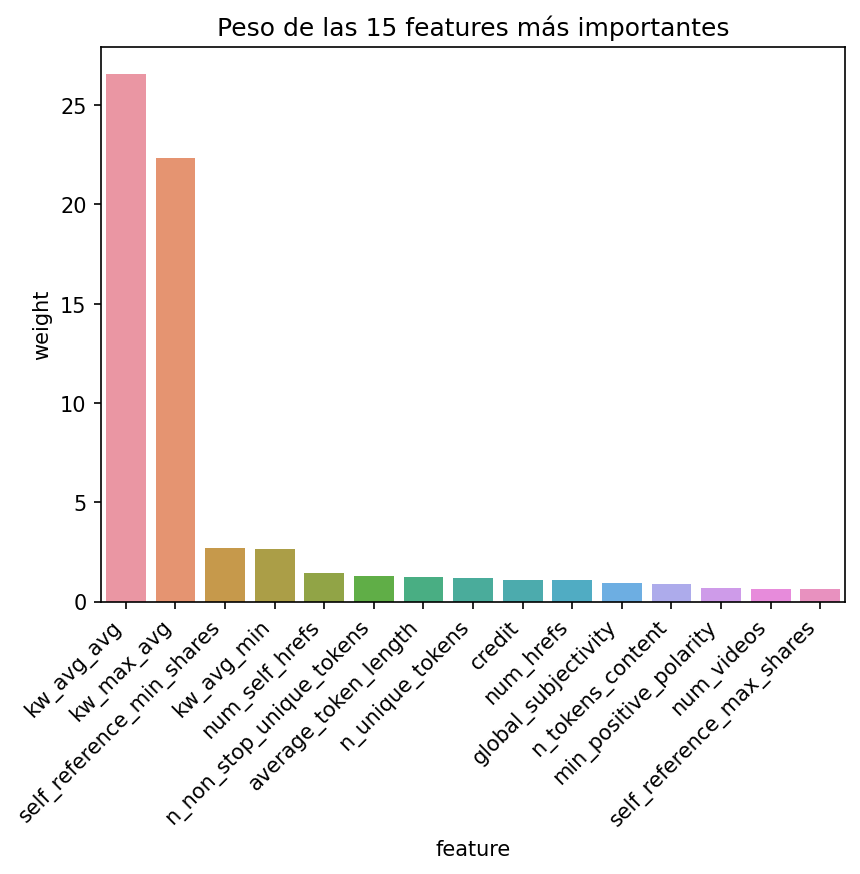

In [53]:
plt.figure(dpi=150)

plt.title("Peso de las 15 features más importantes")
ax = sns.barplot(data=df_graph, x='feature', y='abs_weight', order=column_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_ylabel("weight")
ax.set_xlabel("feature")

# Resultados

In [54]:
binary_preds = model.predict(x_valid)

In [55]:
proba_preds = model.predict_proba(x_valid)[:,1]

In [56]:
print(classification_report(y_valid, binary_preds))

              precision    recall  f1-score   support

       False       0.84      0.99      0.91      3291
        True       0.54      0.07      0.13       688

    accuracy                           0.83      3979
   macro avg       0.69      0.53      0.52      3979
weighted avg       0.79      0.83      0.77      3979



In [57]:
roc_auc_score(y_valid, proba_preds)

0.7086354257206052

# Genero csv

In [ ]:
proba_preds_test = model.predict_proba(x_test)[:,1]

In [ ]:
df_preds = pd.DataFrame(proba_preds_test, columns=['popular prediction'])
df_preds['url'] = df_train['url']
df_preds = df_preds[['url', 'popular prediction']]

In [ ]:
df_preds.to_csv('preds_test.csv')



---


#I DON'T WANT TO PLAY WITH YOU ANYMORE

(Cosas que ya no uso pero guardo por las dudas y mustran los cambios que hice durante el desarrollo)

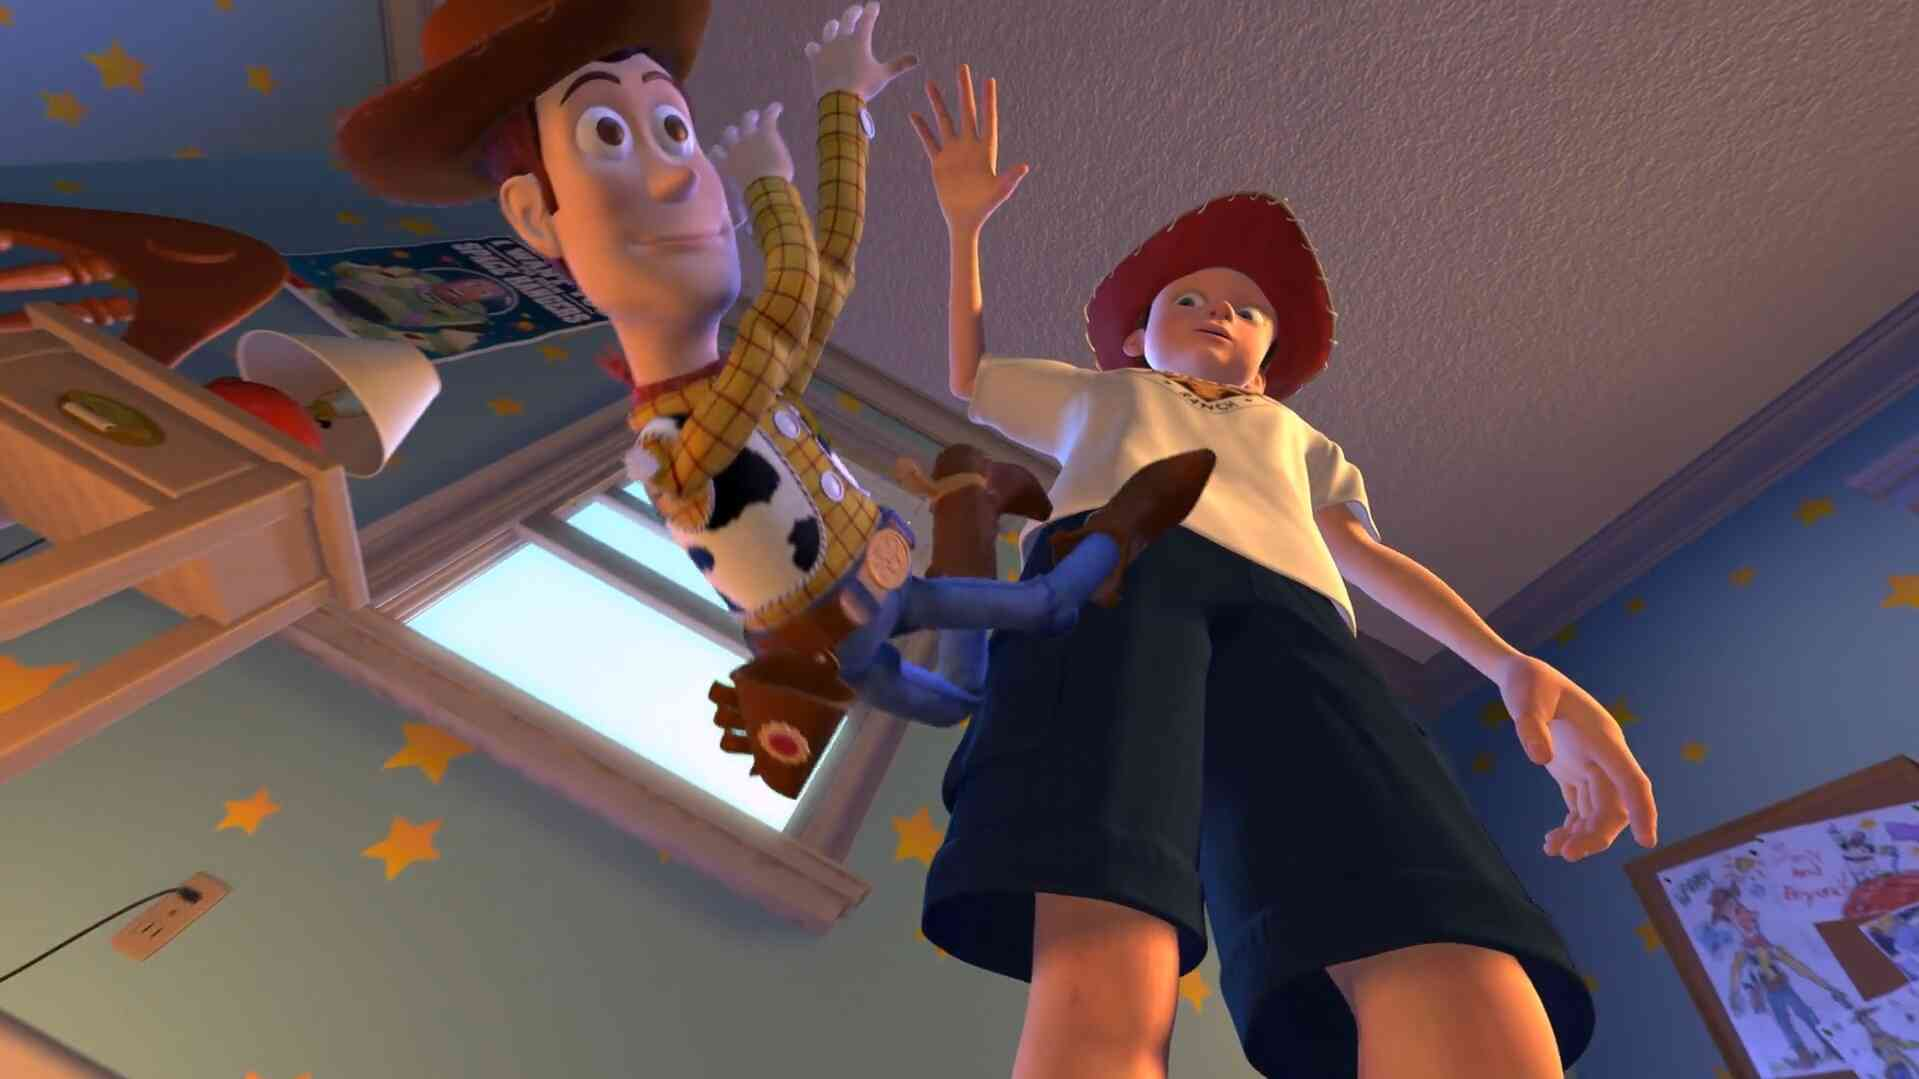

In [ ]:
#Está mal porque debería entrenar una sola vez al label encoder (De esta forma estoy filtrando información a los dataset de validación y testing)
le = LabelEncoder()

array = df_train[['content']].to_numpy()
df_train['content'] = le.fit_transform(array.ravel())

array = df_valid[['content']].to_numpy()
df_valid['content'] = le.fit_transform(array.ravel())

array = df_test[['content']].to_numpy()
df_test['content'] = le.fit_transform(array.ravel())

In [ ]:
#Fill NaNs (Es mejor tener en cuenta los datos de cada columna para decidir como imputar nulos)
df_train.fillna(value=-1.0, inplace=True)
df_valid.fillna(value=-1.0, inplace=True)
df_test.fillna(value=-1.0, inplace=True)